In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import numpy as np
from matplotlib.patches import Patch
import random
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp

In [ ]:
#sampling functions

def sample_snowball(G, initial_size=10, node_percentage=0.1):
    """Expands a set of seed nodes outward in waves until the required percentage is reached."""
    seed_nodes = random.sample(list(G.nodes()), initial_size)
    sampled_nodes = set(seed_nodes)
    queue = list(seed_nodes)

    while queue and len(sampled_nodes) < int(len(G) * node_percentage):
        node = queue.pop(0)
        neighbors = set(G.neighbors(node)) - sampled_nodes
        sampled_nodes.update(neighbors)
        queue.extend(neighbors)

    return G.subgraph(sampled_nodes).copy()
#######################################################
def rsnode(G, node_percentage=0.1):
    #10% of overall nodes
    """Randomly samples a percentage of nodes and retains only edges between them."""
    sampled_nodes = set(random.sample(list(G.nodes()), int(len(G) * node_percentage)))
    sampled_G = G.subgraph(sampled_nodes).copy()  
    return sampled_G
########################################################
def sample_ssp(G, L=100, phi=0.1):
    """
    Implements the Shortest Path-based Sampling (SSP) method.

    Parameters:
        G: NetworkX graph
        L: Number of shortest paths to compute
        phi: Fraction of total nodes to retain in the sampled graph

    Returns:
        Sampled subgraph G_s
    """
    edge_counter = Counter()  # Track frequency of edges 
    nodes = list(G.nodes())
    N = len(nodes)

    # Compute L shortest paths between random, non-adjacent node pairs
    t = 0
    while t < L:
        v_s, v_d = random.sample(nodes, 2)
        if not G.has_edge(v_s, v_d):  # ensure non-adjacency
            try:
                path = nx.shortest_path(G, source=v_s, target=v_d)
                for i in range(len(path) - 1):
                    edge = tuple(sorted((path[i], path[i + 1])))
                    edge_counter[edge] += 1
                t += 1  # only count successful paths
            except nx.NetworkXNoPath:
                pass  # skip pairs with no path

    # Rank edges by frequency of occurrence
    ranked_edges = [edge for edge, _ in edge_counter.most_common()]

    # Select top φ*N nodes from most frequently used edges
    m = int(phi * N)  # number of nodes to retain
    selected_nodes = set()
    for edge in ranked_edges:
        selected_nodes.update(edge)
        if len(selected_nodes) >= m:
            break

    # Generate the sampled graph from the selected nodes
    G_s = G.subgraph(selected_nodes).copy()

    return G_s

In [3]:
def visualizer(g,sg,title):
    # Visualization of the subgraph within the original graph
    plt.figure(figsize=(10, 8))

    pos = nx.spring_layout(g, seed=42)
    # Draw original graph nodes in red
    nx.draw_networkx_nodes(g, pos, node_size=20, node_color="red", alpha=0.5)

    # Draw sampled subgraph nodes in green
    nx.draw_networkx_nodes(sg, pos, node_size=50, node_color="green")

    # Draw edges of the original graph in light gray
    nx.draw_networkx_edges(g, pos, edge_color="gray", width=0.5, alpha=0.3)

    # Draw edges of the sampled subgraph in black
    nx.draw_networkx_edges(sg, pos, edge_color="black", width=1.2)

    legend_elements = [
    Patch(facecolor='green', edgecolor='green', label='Sampled Subgraph Nodes'),
    Patch(facecolor='red', edgecolor='red', label='Original Graph Nodes')
    ]
    #plt.legend(handles=legend_elements)
    plt.title(f"{title}")
    plt.legend()
    plt.show()

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def distribution_visualizer(metric1, metric2, label1, label2, metric_name="Metric", use_kde=True):
    """
    Plot distribution comparison between two graph metrics.

    Args:
        metric1 (list): Metric values from graph 1.
        metric2 (list): Metric values from graph 2.
        label1 (str): Label for graph 1 (e.g., "Original").
        label2 (str): Label for graph 2 (e.g., "Sampled").
        metric_name (str): Name of the metric (e.g., "Closeness Centrality").
        use_kde (bool): If True, plots smooth KDE curves; else, uses histograms.
    """
    plt.figure(figsize=(10, 6))

    if use_kde:
        sns.kdeplot(metric1, label=f"{label1} - {metric_name}", fill=True, linewidth=2)
        sns.kdeplot(metric2, label=f"{label2} - {metric_name}", fill=True, linewidth=2)
    else:
        plt.hist(metric1, bins=30, alpha=0.5, label=f"{label1} - {metric_name}", color='blue', density=True)
        plt.hist(metric2, bins=30, alpha=0.5, label=f"{label2} - {metric_name}", color='orange', density=True)

    plt.title(f"{metric_name} Distribution Comparison")
    plt.xlabel(metric_name)
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()


In [5]:
def evaluator(graph):
    num_nodes = len(graph.nodes())
    num_edges = len(graph.edges())
    
    avg_degree = sum(dict(graph.degree()).values()) / num_nodes if num_nodes > 0 else 0
    max_edges = num_nodes * (num_nodes - 1) / 2
    density = num_edges / max_edges if max_edges > 0 else 0

    if nx.is_connected(graph):
        eccentricity = nx.eccentricity(graph)
        radius = nx.radius(graph)
        diameter = nx.diameter(graph)
    else:
        eccentricity, radius, diameter = None, None, None

    global_clustering = nx.transitivity(graph)

    cc = list(nx.closeness_centrality(graph).values())
    bc = list(nx.betweenness_centrality(graph).values())
    dc = list(nx.degree_centrality(graph).values())
    try:
        ec = list(nx.eigenvector_centrality(graph, max_iter=1000).values())
    except nx.NetworkXException:
        ec = None

    essentials = {
        "Number of Nodes": num_nodes,
        "Number of Edges": num_edges,
        "Average Degree": avg_degree,
        "Density": density,
        "Radius": radius,
        "Diameter": diameter,
        "Global Clustering Coefficient": global_clustering
    }

    return essentials, cc, bc, ec, dc


In [6]:
#Original Graph
g1 = nx.erdos_renyi_graph(2500, 0.1,seed=42)  

In [7]:
oessentials,occ,obc,oec,odc=evaluator(g1)
oessentials

{'Number of Nodes': 2500,
 'Number of Edges': 312954,
 'Average Degree': 250.3632,
 'Density': 0.10018535414165666,
 'Radius': 2,
 'Diameter': 2,
 'Global Clustering Coefficient': 0.1001175460871966}

In [8]:
#Creation of the sampled graphs
#Snowball samplings
g1m1a=sample_snowball(g1,10,0.1)
g1m1b=sample_snowball(g1,10,0.25)
g1m1c=sample_snowball(g1,10,0.5)
g1m1d=sample_snowball(g1,10,0.75)

#Random nodes samplings
g1m2a=rsnode(g1,0.1)
g1m2b=rsnode(g1,0.25)
g1m2c=rsnode(g1,0.5)
g1m2d=rsnode(g1,0.75)

#Shortest path samplings
g1m3a=sample_ssp(g1,100,0.1)
g1m3b=sample_ssp(g1,100,0.25)
g1m3c=sample_ssp(g1,100,0.5)
g1m3d=sample_ssp(g1,100,0.75)

In [9]:
#Nomenclature for simplicity
graph_objects=[
    g1m1a,g1m1b,g1m1c,g1m1d,
    g1m2a,g1m2b,g1m2c,g1m2d,
    g1m3a,g1m3b,g1m3c,g1m3d
    ]

graph_names=[
    'g1m1a','g1m1b','g1m1c','g1m1d',
    'g1m2a','g1m2b','g1m2c','g1m2d',
    'g1m3a','g1m3b','g1m3c','g1m3d'
    ]

In [10]:
#Evaluation and storing of results
results={}
for graph, name in zip(graph_objects, graph_names):
    essentials, cc, bc, ec, dc = evaluator(graph)
    results[name] = {
        "essentials": essentials,
        "cc": cc,
        "bc": bc,
        "ec": ec,
        "dc": dc
    }

In [11]:
#sample output check
print(results['g1m1a']['essentials'] ) # Gets the essentials for g1m1a
len(results['g1m3b']['dc'])  # Gets the degree centrality for m3b


{'Number of Nodes': 251, 'Number of Edges': 3362, 'Average Degree': 26.788844621513945, 'Density': 0.10715537848605577, 'Radius': 2, 'Diameter': 3, 'Global Clustering Coefficient': 0.15029417480874221}


264

In [12]:
#visualizer(g1,g1m1a,'Snowball sampling vs Original')

In [13]:
#visualizer(g1,g1m2a,'Random node sampling vs Original')

In [14]:
#visualizer(g1,g1m3a,'Shortest path sampling vs Original')

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

def multi_metric_distribution_visualizer(original_metrics_dict, sampled_metrics_dicts, metric_labels,title):
    """
    Plots separate graphs for each centrality metric showing all sampling distributions.

    :param original_metrics_dict: Dict with keys as metric names (e.g., 'Degree') and values as original metric lists
    :param sampled_metrics_dicts: Dict of dicts: {metric_name: {sample_label: metric_list}}
    :param metric_labels: List of metric names (e.g., ['Degree', 'Closeness', 'Betweenness', 'Eigenvector'])
    """
    for metric in metric_labels:
        plt.figure(figsize=(10, 6))
        
        # Plot original
        sns.kdeplot(original_metrics_dict[metric], label="Original", color='black', linewidth=2,fill=True)
        
        # Plot all sampled distributions for this metric
        for sample_label, metric_values in sampled_metrics_dicts[metric].items():
            sns.kdeplot(metric_values, label=sample_label,fill=True)

        plt.xlabel(f'{metric} Centrality')
        plt.ylabel('Density')
        plt.title(f'{metric} Centrality Distribution - Original vs Samples({title})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


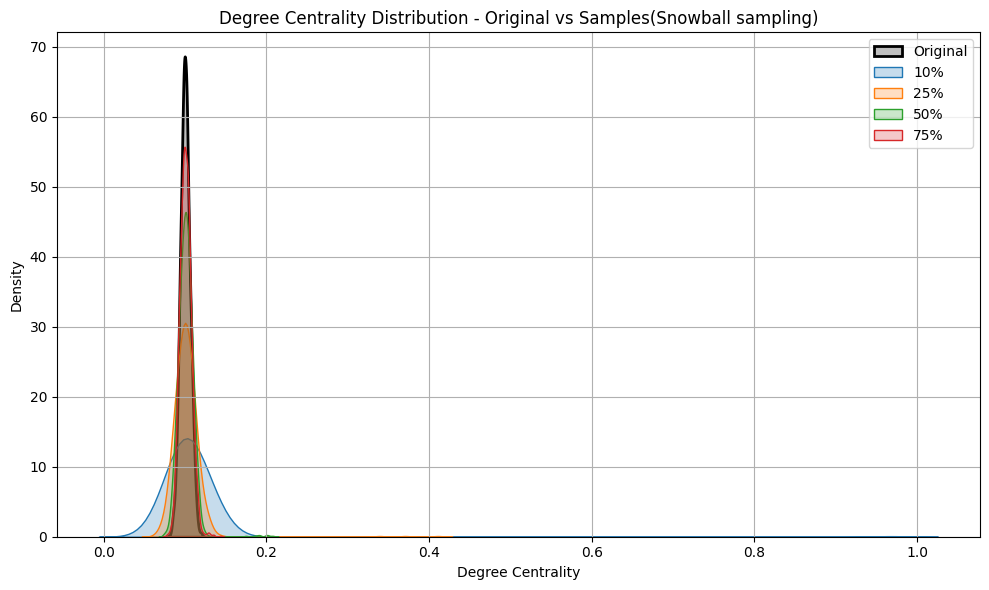

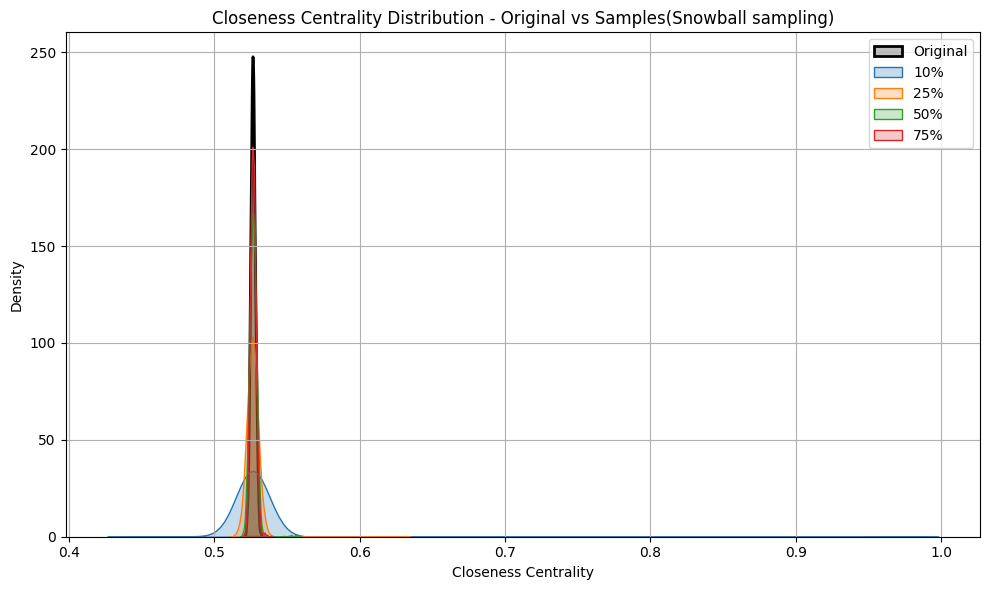

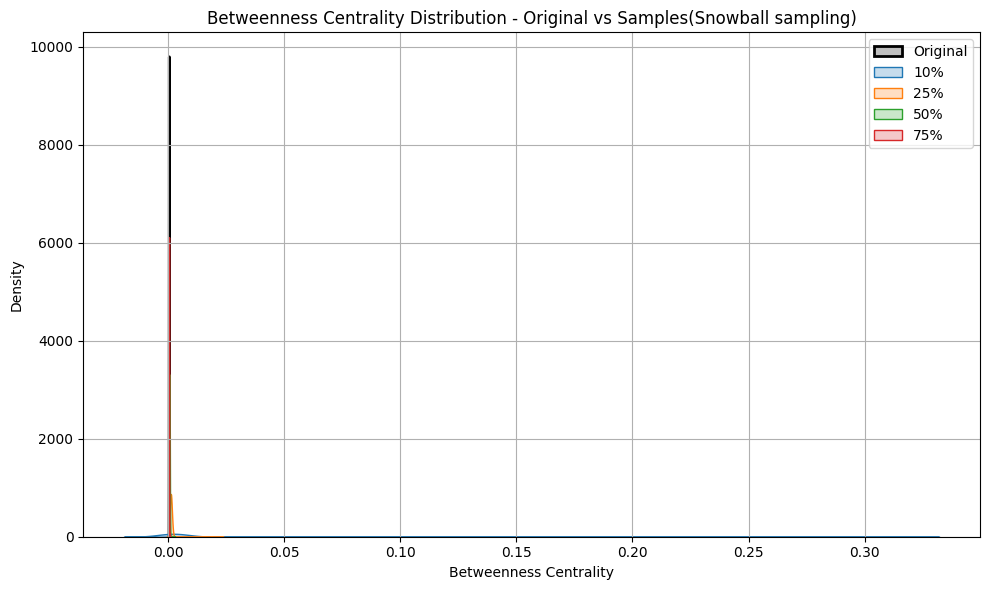

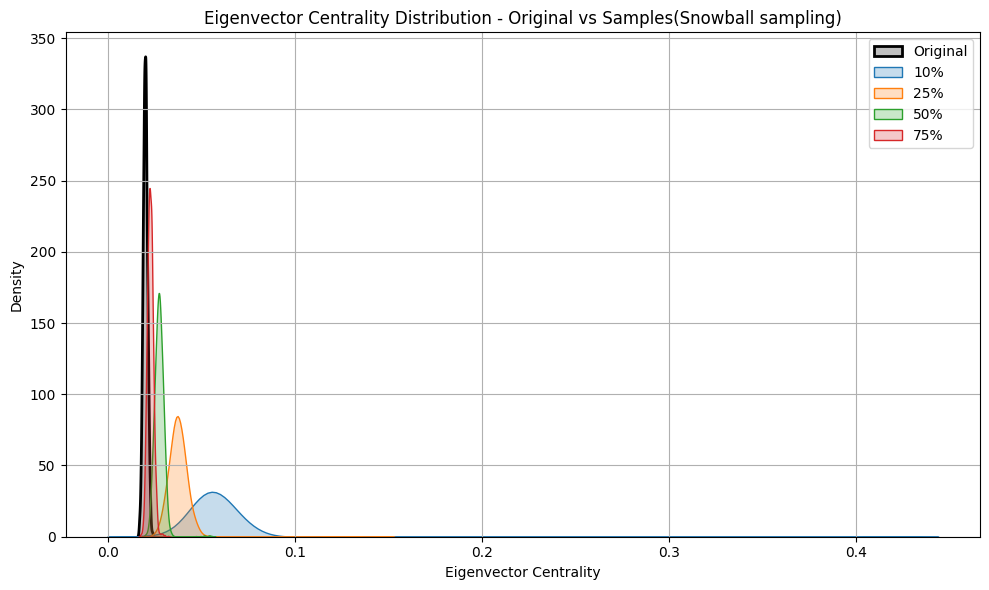

In [ ]:
# Define sample sizes
sample_sizes = {'10%': 'a', '25%': 'b', '50%': 'c', '75%': 'd'}

# Define metric labels
metric_names = ['Degree', 'Closeness', 'Betweenness', 'Eigenvector']

# Original centrality values
original_metrics = {
    'Degree': odc,
    'Closeness': occ,
    'Betweenness': obc,
    'Eigenvector': oec
}

# Sampled centrality values
sampled_metrics = {
    'Degree': {label: results[f"g1m1{suffix}"]['dc'] for label, suffix in sample_sizes.items()},
    'Closeness': {label: results[f"g1m1{suffix}"]['cc'] for label, suffix in sample_sizes.items()},
    'Betweenness': {label: results[f"g1m1{suffix}"]['bc'] for label, suffix in sample_sizes.items()},
    'Eigenvector': {label: results[f"g1m1{suffix}"]['ec'] for label, suffix in sample_sizes.items()}
}

# Call the function
multi_metric_distribution_visualizer(original_metrics, sampled_metrics, metric_names,title='Snowball sampling')


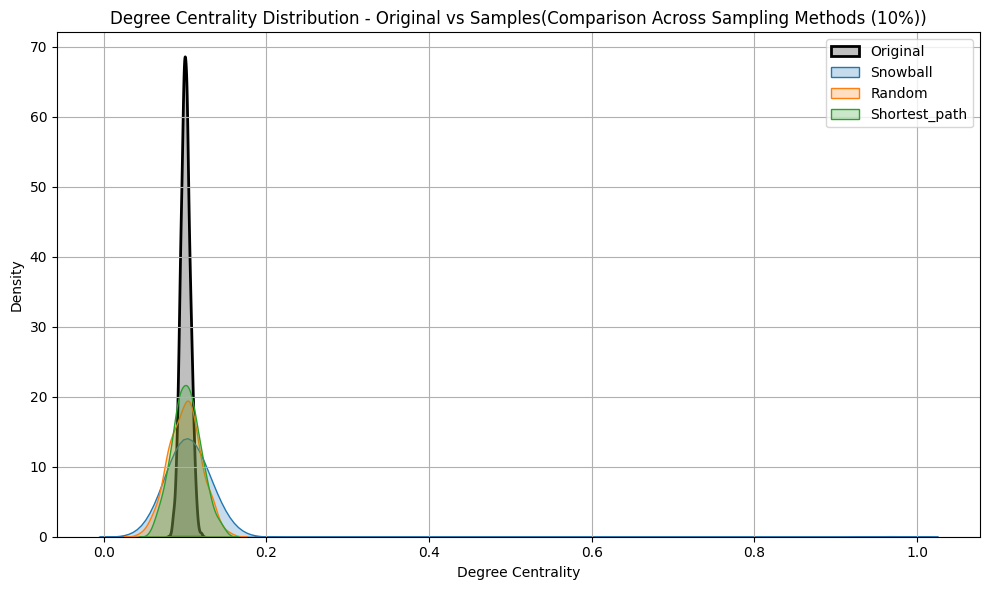

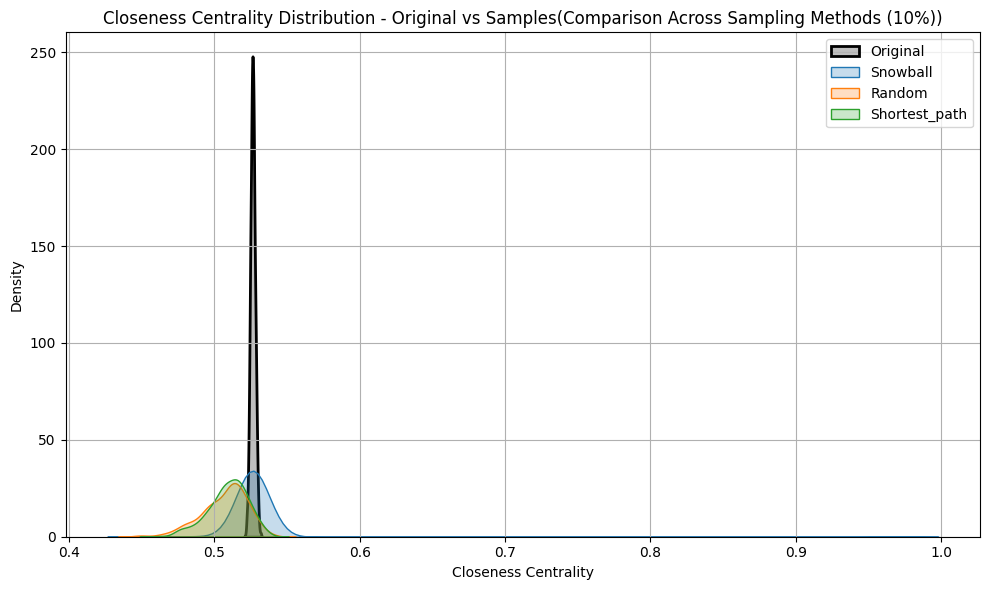

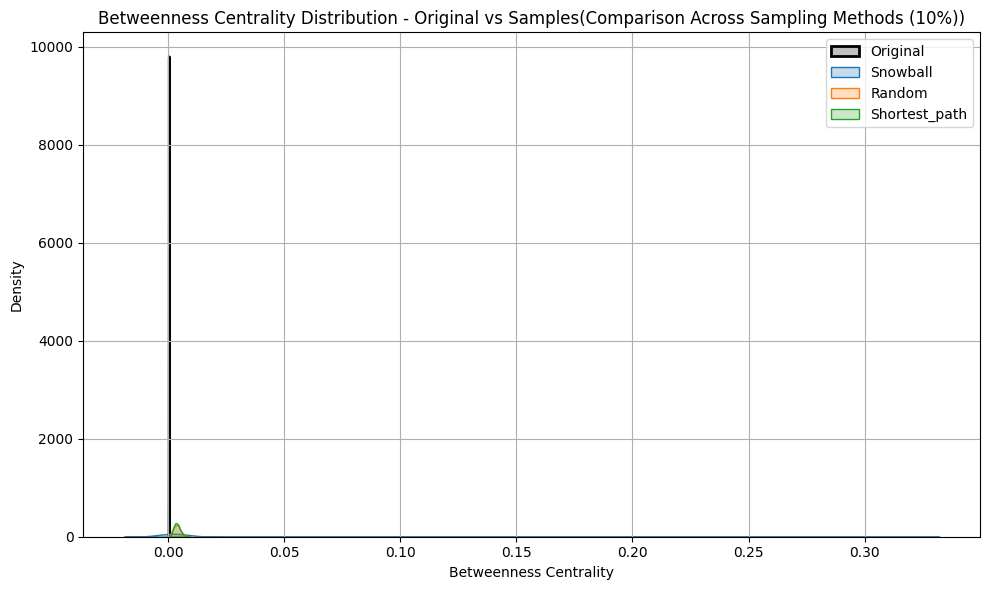

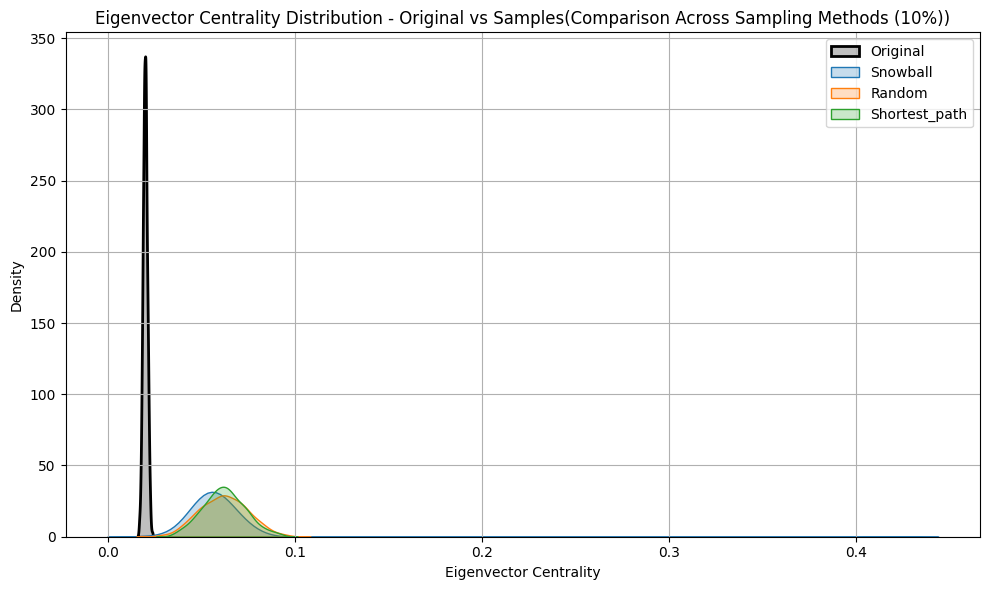

In [ ]:
# Mapping sampling method names to infix codes
model_names = {'Snowball': 'm1', 'Random': 'm2', 'Shortest_path': 'm3'}

# Define metric labels
metric_names = ['Degree', 'Closeness', 'Betweenness', 'Eigenvector']

# Original centrality values
original_metrics = {
    'Degree': odc,
    'Closeness': occ,
    'Betweenness': obc,
    'Eigenvector': oec
}

metric_code_map = {
    'Degree': 'dc',
    'Closeness': 'cc',
    'Betweenness': 'bc',
    'Eigenvector': 'ec'
}

# Sampled centrality values (for 10% sampling, i.e., suffix 'a')
sample_suffix = 'a'
graph_prefix = 'g1'

sampled_metrics = {}
for metric in metric_names:
    metric_code = metric_code_map[metric]
    sampled_metrics[metric] = {
        label: results[f"{graph_prefix}{infix}{sample_suffix}"][metric_code]
        for label, infix in model_names.items()
    }

# call function
multi_metric_distribution_visualizer(
    original_metrics,
    sampled_metrics,
    metric_names,
    title='Comparison Across Sampling Methods (10%)'
)


In [18]:
results["g1"] = {
    "essentials":oessentials,
    "cc": occ,
    "bc": obc,
    "ec": oec,
    "dc": odc
}

In [19]:
import pandas as pd
import numpy as np
from scipy.stats import wasserstein_distance

def compute_intra_strategy_metrics(results, strategy_name, suffix):
    records = []

    for size, size_letter in [(0.1, "a"), (0.25, "b"), (0.5, "c"), (0.75, "d")]:
        graph_key = f"g1{suffix}{size_letter}"
        metrics = results.get(graph_key, {})
        row = {
            "Strategy": strategy_name,
            "Sampling Size": size,
            "Closeness": np.nan,
            "Betweenness": np.nan,
            "Eigenvector": np.nan,
            "Degree": np.nan
        }
        for metric_type, key in [("Closeness", "cc"), ("Betweenness", "bc"), 
                                 ("Eigenvector", "ec"), ("Degree", "dc")]:
            original = np.array(results["g1"].get(key, []))
            sampled = np.array(metrics.get(key)) if metrics.get(key) is not None else []
            if len(sampled) > 0:
                try:
                    dist = wasserstein_distance(original, sampled)
                except Exception:
                    dist = np.nan
            else:
                dist = np.nan
            row[metric_type] = dist
        records.append(row)

    return pd.DataFrame(records)


In [20]:
def compute_inter_strategy_metrics(results, size, size_letter):
    records = []

    for strategy_name, suffix in [("Snowball", "m1"), ("Random", "m2"), ("SSP", "m3")]:
        graph_key = f"g1{suffix}{size_letter}"
        metrics = results.get(graph_key, {})
        row = {
            "Strategy": strategy_name,
            "Sampling Size": size,
            "Closeness": np.nan,
            "Betweenness": np.nan,
            "Eigenvector": np.nan,
            "Degree": np.nan
        }
        for metric_type, key in [("Closeness", "cc"), ("Betweenness", "bc"), 
                                 ("Eigenvector", "ec"), ("Degree", "dc")]:
            original = np.array(results["g1"].get(key, []))
            sampled = np.array(metrics.get(key)) if metrics.get(key) is not None else []
            if len(sampled) > 0:
                try:
                    dist = wasserstein_distance(original, sampled)
                except Exception:
                    dist = np.nan
            else:
                dist = np.nan
            row[metric_type] = dist
        records.append(row)

    return pd.DataFrame(records)


In [21]:
# Intra-strategy (per strategy)
df_intra_snowball = compute_intra_strategy_metrics(results, "Snowball", "m1")
df_intra_random = compute_intra_strategy_metrics(results, "Random", "m2")
df_intra_ssp = compute_intra_strategy_metrics(results, "SSP", "m3")

# Inter-strategy (per sampling size)
df_inter_10 = compute_inter_strategy_metrics(results, 0.1, "a")
df_inter_25 = compute_inter_strategy_metrics(results, 0.25, "b")
df_inter_50 = compute_inter_strategy_metrics(results, 0.5, "c")
df_inter_75 = compute_inter_strategy_metrics(results, 0.75, "d")


In [22]:
all_intra = pd.concat([df_intra_snowball, df_intra_random, df_intra_ssp], ignore_index=True)
all_inter = pd.concat([df_inter_10, df_inter_25, df_inter_50, df_inter_75], ignore_index=True)


In [23]:
all_intra

,Strategy,Sampling Size,Closeness,Betweenness,Eigenvector,Degree
0,Snowball,0.10,0.005983,0.003250,0.038072,0.015368
1,Snowball,0.25,0.001833,0.000986,0.017885,0.005890
2,Snowball,0.50,0.000658,0.000327,0.007515,0.002347
3,Snowball,0.75,0.000258,0.000105,0.002710,0.000927
4,Random,0.10,0.019936,0.003574,0.041988,0.011251
5,Random,0.25,0.001629,0.001089,0.019761,0.004470
6,Random,0.50,0.000582,0.000361,0.008214,0.002103
7,Random,0.75,0.000219,0.000120,0.003074,0.000791
8,SSP,0.10,0.017468,0.003533,0.042287,0.009320
9,SSP,0.25,0.012299,0.003239,0.040587,0.010841


In [24]:
all_inter

,Strategy,Sampling Size,Closeness,Betweenness,Eigenvector,Degree
0,Snowball,0.10,0.005983,0.003250,0.038072,0.015368
1,Random,0.10,0.019936,0.003574,0.041988,0.011251
2,SSP,0.10,0.017468,0.003533,0.042287,0.009320
3,Snowball,0.25,0.001833,0.000986,0.017885,0.005890
4,Random,0.25,0.001629,0.001089,0.019761,0.004470
5,SSP,0.25,0.012299,0.003239,0.040587,0.010841
6,Snowball,0.50,0.000658,0.000327,0.007515,0.002347
7,Random,0.50,0.000582,0.000361,0.008214,0.002103
8,SSP,0.50,0.014400,0.003294,0.040745,0.009739
9,Snowball,0.75,0.000258,0.000105,0.002710,0.000927


In [ ]:
# Grouped correlation results
grouped_correlations = []

metrics = ["Closeness", "Betweenness", "Eigenvector", "Degree"]

# Group by 'Strategy' and calculate correlation per metric
for strategy, group in all_intra.groupby("Strategy"):
    result = {"Strategy": strategy}
    for metric in metrics:
        corr = group["Sampling Size"].corr(group[metric])
        result[metric] = corr
    grouped_correlations.append(result)

# Convert to a DataFrame
strategy_corr_df = pd.DataFrame(grouped_correlations)

#  re-order columns
strategy_corr_df = strategy_corr_df[["Strategy"] + metrics]

strategy_corr_df


,Strategy,Closeness,Betweenness,Eigenvector,Degree
0,Random,-0.741411,-0.854450,-0.921763,-0.891843
1,SSP,-0.039456,-0.474826,-0.680739,0.105216
2,Snowball,-0.851987,-0.854379,-0.922391,-0.885448


In [ ]:
import pandas as pd

def compute_graph_metrics_for_sampling(results, strategy_name, suffix):
    records = []
    s_no = 1

    for size, size_letter in [(0.1, "a"), (0.25, "b"), (0.5, "c"), (0.75, "d")]:
        graph_key = f"g1{suffix}{size_letter}"
        essentials = results.get(graph_key, {}).get("essentials", {})
        
        # If essentials data is available
        if essentials:
            row = {
                "S.no": s_no,
                "Strategy": strategy_name,
                "Sampling Size": size,
                "Number of Nodes": essentials.get("Number of Nodes", np.nan),
                "Number of Edges": essentials.get("Number of Edges", np.nan),
                "Average Degree": essentials.get("Average Degree", np.nan),
                "Density": essentials.get("Density", np.nan),
                "Radius": essentials.get("Radius", np.nan),
                "Diameter": essentials.get("Diameter", np.nan),
                "Global Clustering Coefficient": essentials.get("Global Clustering Coefficient", np.nan)
            }
            records.append(row)
            s_no += 1

    return pd.DataFrame(records)

df_snowball = compute_graph_metrics_for_sampling(results, "Snowball", "m1")
df_random = compute_graph_metrics_for_sampling(results, "Random", "m2")
df_ssp = compute_graph_metrics_for_sampling(results, "SSP", "m3")

# Combine all dataframes into one
df_all = pd.concat([df_snowball, df_random, df_ssp], ignore_index=True)

# Display the result
df_all


,S.no,Strategy,Sampling Size,Number of Nodes,Number of Edges,Average Degree,Density,Radius,Diameter,Global Clustering Coefficient
0,1,Snowball,0.10,251,3362,26.788845,0.107155,2,3,0.150294
1,2,Snowball,0.25,670,22761,67.943284,0.101559,2,3,0.107868
2,3,Snowball,0.50,1310,86554,132.143511,0.100950,2,2,0.101813
3,4,Snowball,0.75,1935,188224,194.546770,0.100593,2,2,0.100576
4,1,Random,0.10,250,3102,24.816000,0.099663,3,3,0.099024
5,2,Random,0.25,625,19343,61.897600,0.099195,2,3,0.098636
6,3,Random,0.50,1250,77858,124.572800,0.099738,2,2,0.099844
7,4,Random,0.75,1875,175836,187.558400,0.100085,2,2,0.100003
8,1,SSP,0.10,250,3163,25.304000,0.101622,3,3,0.098959
9,2,SSP,0.25,264,3634,27.530303,0.104678,3,3,0.103864


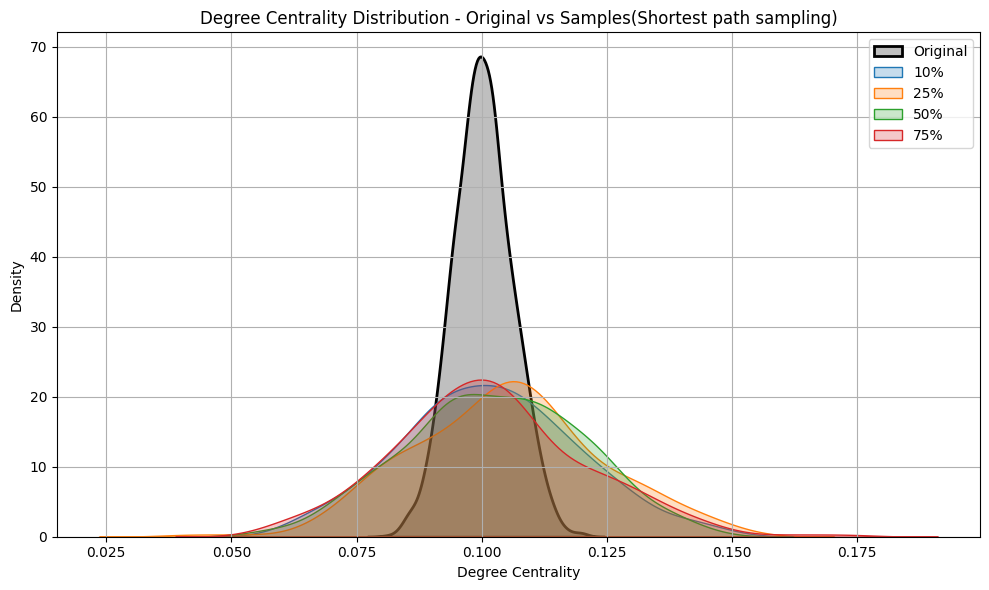

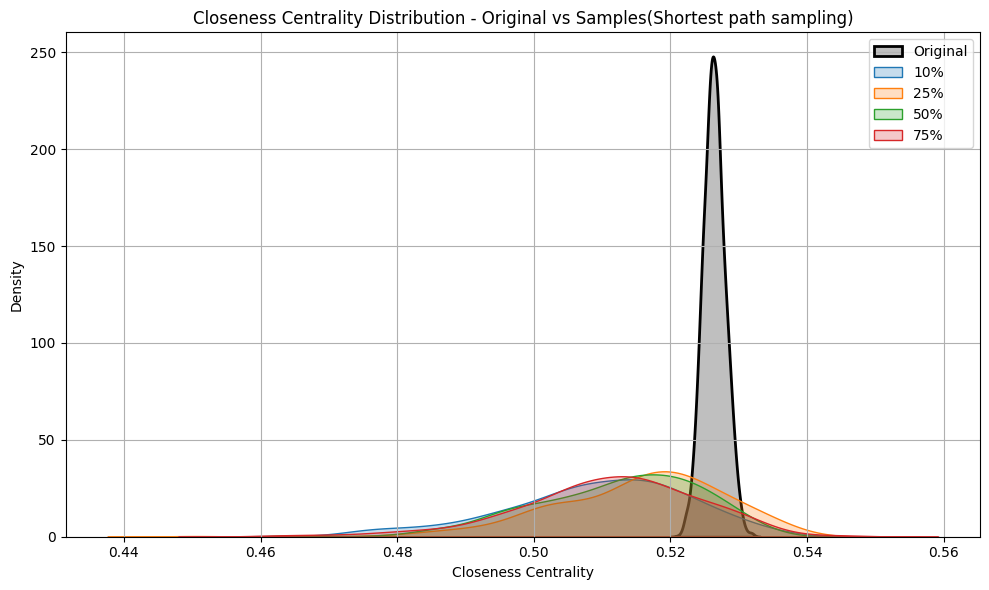

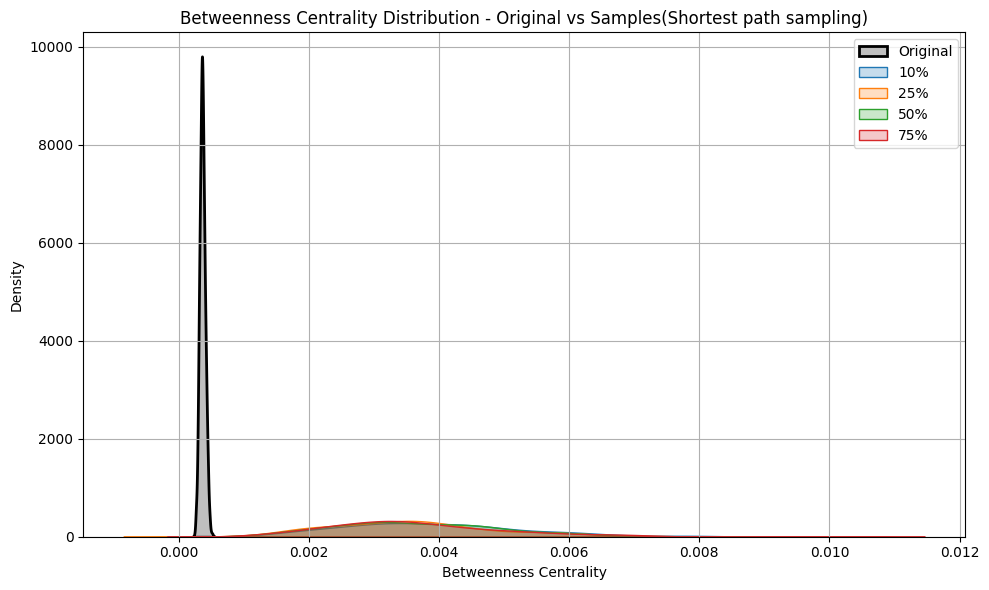

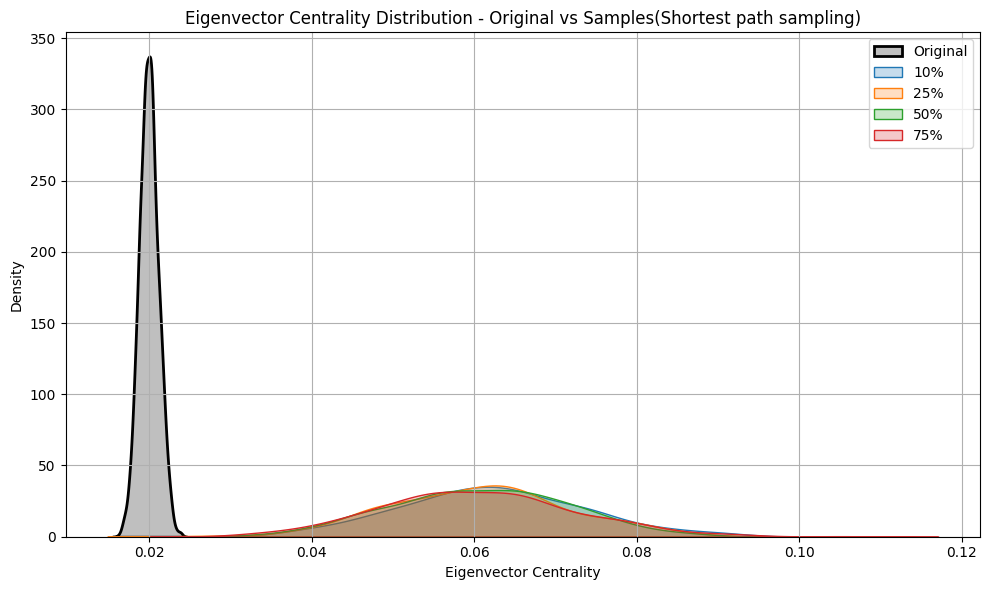

In [ ]:
# Define sample sizes
sample_sizes = {'10%': 'a', '25%': 'b', '50%': 'c', '75%': 'd'}

# Define metric labels
metric_names = ['Degree', 'Closeness', 'Betweenness', 'Eigenvector']

# Original centrality values
original_metrics = {
    'Degree': odc,
    'Closeness': occ,
    'Betweenness': obc,
    'Eigenvector': oec
}

# Sampled centrality values
sampled_metrics = {
    'Degree': {label: results[f"g1m3{suffix}"]['dc'] for label, suffix in sample_sizes.items()},
    'Closeness': {label: results[f"g1m3{suffix}"]['cc'] for label, suffix in sample_sizes.items()},
    'Betweenness': {label: results[f"g1m3{suffix}"]['bc'] for label, suffix in sample_sizes.items()},
    'Eigenvector': {label: results[f"g1m3{suffix}"]['ec'] for label, suffix in sample_sizes.items()}
}

# Call the function
multi_metric_distribution_visualizer(original_metrics, sampled_metrics, metric_names,title='Shortest path sampling')
